In [1]:
import os.path
import pickle
import string
from collections import Counter

import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB

nltk.download('stopwords')


def process_text(df):
    df['Summary'].fillna('', inplace=True)
    df['Text'].fillna('', inplace=True)
    df['Summary'] = df['Summary'].apply(stem_sent)
    df['Text'] = df['Text'].apply(stem_sent)
    return df


def stem_sent(text):
    if not text:
        return

    stemmer = SnowballStemmer('english')
    text = text.lower()

    words = word_tokenize(text)
    result = []
    for w in words:
        # remove all punctuation
        if w in string.punctuation or w in stopwords.words('english'):
            continue
        result.append(stemmer.stem(w))
    return ' '.join(result)


def calc_counter(text, vocab_counter):
    counter = Counter(text.split())
    vocab_counter += counter


def one_hot(text, vocabulary):
    vec = [0] * (len(vocabulary) + 1)
    counter = Counter(text.split())
    for k, v in counter.items():
        if k in vocabulary:
            vec[vocabulary[k]] = v
        else:
            vec[0] += v
    return vec


def convert2Id(text, id_dict):
    if text in id_dict:
        return id_dict[text]
    else:
        return 0



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\97661\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:

# Load files into DataFrames
print('loading data...')
if os.path.exists('./data/X_train_stem.csv'):
    X_train = pd.read_csv("./data/X_train_stem.csv", index_col=0)
    X_submission = pd.read_csv("./data/X_test_stem.csv", index_col=0)
    X_train[['Summary', 'Text']] = X_train[['Summary', 'Text']].astype(str)
    X_submission[['Summary', 'Text']] = X_submission[['Summary', 'Text']].astype(str)
else:
    X_train = pd.read_csv("./data/X_train.csv", index_col=0)
    X_submission = pd.read_csv("./data/X_test.csv", index_col=0)
    X_train[['Summary', 'Text']] = X_train[['Summary', 'Text']].astype(str)
    X_submission[['Summary', 'Text']] = X_submission[['Summary', 'Text']].astype(str)
    # stem word
    print('stem data')
    X_train = process_text(X_train)
    X_train.to_csv("./data/X_train_stem.csv")
    X_submission = process_text(X_submission)
    X_submission.to_csv("./data/X_test_stem.csv")

# X_train = X_train.iloc[:100]

# Split training set into training and testing set
# X_train, X_test, Y_train, Y_test = train_test_split(
#     X_train.drop(['Score'], axis=1),
#     X_train['Score'],
#     test_size=1 / 4.0,
#     random_state=0
# )

# make vocabulary
# print('building vocabulary...')
# if os.path.exists('./data/vocabulary.pickle'):
#     with open("./data/counter.pickle", "rb") as f:
#         vocab_counter = pickle.load(f)
#     with open("./data/vocabulary.pickle", "rb") as f:
#         vocabulary = pickle.load(f)
# else:
#     vocab_counter = Counter()
#     X_train['Summary'].apply(calc_counter, args=(vocab_counter,))
#     X_train['Text'].apply(calc_counter, args=(vocab_counter,))
#     # vocabulary index start from 1. 0 used for any unknown word
#     vocabulary = dict(zip(list(vocab_counter), range(1, len(vocab_counter) + 1)))
#     print(vocab_counter.most_common(500))
#     print(list(sorted(vocabulary.items(), key=lambda x: x[1]))[:500])
#     with open('./data/counter.pickle', 'wb') as f:
#         pickle.dump(vocab_counter, f)
#     with open('./data/vocabulary.pickle', 'wb') as f:
#         pickle.dump(vocabulary, f)

# # make word one-hot
# print('building word ont-hot')
# X_train['OnehotS'] = X_train['Summary'].apply(one_hot, args=(vocabulary,))
# X_train['OnehotT'] = X_train['Text'].apply(one_hot, args=(vocabulary,))

loading data...


In [3]:
# extract year feature
# print('extract year feature')
# X_train['Year'] = pd.to_datetime(X_train['Time'], unit='s').dt.year

# convert productId and userId to int id
print("convert product id and user id to int id")
if os.path.exists('product2Id.pickle'):
    with open('./data/product2Id.pickle', 'wb') as f1, open('./data/user2Id.pickle', 'wb') as f2:
        product2Id = pickle.load(f1)
        User2Id = pickle.load(f2)
else:
    uniqueP = X_train['ProductId'].unique()
    uniqueS = X_train['UserId'].unique()

    product2Id = dict(zip(uniqueP.tolist(), range(1, len(uniqueP) + 1)))
    User2Id = dict(zip(uniqueS.tolist(), range(1, len(uniqueS) + 1)))

    with open('./data/product2Id.pickle', 'wb') as f1, open('./data/user2Id.pickle', 'wb') as f2:
        pickle.dump(product2Id, f1)
        pickle.dump(User2Id, f2)

X_train["ProductId"] = X_train["ProductId"].apply(convert2Id, args=(product2Id,))
X_train["UserId"] = X_train["UserId"].apply(convert2Id, args=(User2Id,))
X_train.head()

convert product id and user id to int id


,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpfulness
Id,,,,,,,,,
0,1,1,0,0,4.0,1203984000,good version classic,charm version classic dicken 's tale henri win...,0.0
1,1,2,0,0,3.0,1388361600,good move,good emot move christma carol dicken like chri...,0.0
2,1,3,0,0,3.0,1388361600,winkler 's perform ok best,n't get wrong winkler wonder charact actor wou...,0.0
3,1,4,0,0,5.0,1202860800,'s enjoy twist classic stori,henri winkler good twist classic stori convent...,0.0
4,1,5,0,0,4.0,1387670400,best scroog yet,one best scroog movi henri winkler outdo cast ...,0.0


In [4]:
# Split training set into training and testing set
x_train, x_test, y_train, y_test = train_test_split(
    X_train.drop(['Score'], axis=1),
    X_train['Score'],
    test_size=1 / 5.0,
    random_state=0
)

In [5]:
x_train.head()

,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,Helpfulness
Id,,,,,,,,
772191,18587,58956,3,4,1126310400,chao feminist film,overwhelm guilt result redempt often film grad...,0.75
936535,25204,56897,0,0,1199750400,would give zero star could,want five dollar back movi stole near two hour...,0.00
1216600,36091,101398,0,0,1247097600,love workout game,game make sweat push unlik wii fit game realli...,0.00
233568,3432,21338,0,0,1364860800,say,say has'nt said already.clint eastwood 2nd bes...,0.00
828139,20759,10593,30,30,1122508800,see small screen ...,fan rex stout book star fat nero wolf cheer ar...,1.00


In [15]:
# build TFIDF
print("building TFIDF")
vectorizeS = TfidfVectorizer(stop_words={'english'}, min_df=15)
vectorizeT = TfidfVectorizer(stop_words={'english'}, min_df=20, ngram_range=(2,2))
vectorizeS.fit(x_train['Summary'])
vectorizeT.fit(x_train['Text'])

building TFIDF


TfidfVectorizer(min_df=20, ngram_range=(2, 2), stop_words={'english'})

In [14]:
print(len(vectorizeS.vocabulary_))
print(len(vectorizeS.stop_words_))

print(len(vectorizeT.vocabulary_))
print(len(vectorizeT.stop_words_))

import math
idf_dict = {}
for word, index in vectorizeS.vocabulary_.items():
    idf_dict[word] = len(X_train) /  math.exp(vectorizeS.idf_[index]) 

print(vectorizeS.transform(['dicken updat']).shape)
print(vectorizeT.transform(['favorit movi mine long time henri winkler great modern day scroog mani movi give new twist dicken one true origin stori set depress']).shape)

10643
53778
764041
19588231
(1, 10643)
(1, 764041)


In [8]:
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

# train naive bayes model
print('training naive bayes')
cnb_s = ComplementNB()
cnb_t = ComplementNB()
TfidfS = vectorizeS.transform(x_train['Summary'])
TfidfT = vectorizeT.transform(x_train['Text'])

# resultS = cross_validate(cnb_s, TfidfS, y_train, )
# resultT = cross_validate(cnb_t, TfidfT, y_train, )

# print(resultS)
# print(resultT)

cnb_s.fit(TfidfS, y_train)
x_train['ScoreS'] = cnb_s.predict(TfidfS)
print(accuracy_score(y_train, x_train['ScoreS']))

cnb_t.fit(TfidfT, y_train)
x_train['ScoreT'] = cnb_t.predict(TfidfT)
print(accuracy_score(y_train, x_train['ScoreT']))

training naive bayes
0.5424435567688051
0.7734542846051881


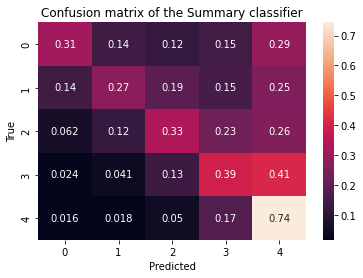

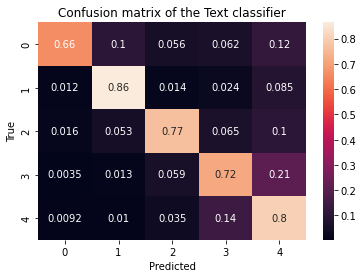

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Plot a confusion matrix
cm = confusion_matrix(x_train['ScoreS'], y_train, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the Summary classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot a confusion matrix
cm = confusion_matrix(x_train['ScoreT'], y_train, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the Text classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [10]:
print((x_train['ScoreS'] - y_train).mean())
# print((x_train['ScoreS'] - y_train).max())
df = pd.DataFrame(x_train['ScoreS'] - y_train)
print(df.groupby(0).size())
# print(df.groupby(['0'], axis=1).count())
x_train.head()

-0.1646831111262171
0
-4.0     35591
-3.0     30153
-2.0     57770
-1.0    164579
 0.0    606466
 1.0    152095
 2.0     46376
 3.0     16009
 4.0      8987
dtype: int64


,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,Helpfulness,ScoreS,ScoreT
Id,,,,,,,,,,
772191,18587,58956,3,4,1126310400,chao feminist film,overwhelm guilt result redempt often film grad...,0.75,2.0,4.0
936535,25204,56897,0,0,1199750400,would give zero star could,want five dollar back movi stole near two hour...,0.00,1.0,1.0
1216600,36091,101398,0,0,1247097600,love workout game,game make sweat push unlik wii fit game realli...,0.00,5.0,5.0
233568,3432,21338,0,0,1364860800,say,say has'nt said already.clint eastwood 2nd bes...,0.00,1.0,5.0
828139,20759,10593,30,30,1122508800,see small screen ...,fan rex stout book star fat nero wolf cheer ar...,1.00,4.0,5.0


In [11]:
x_train = x_train.drop(['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Summary', 'Text'], axis=1)

x_train.head()

,ProductId,UserId,Time,Helpfulness,ScoreS,ScoreT
Id,,,,,,
772191,18587,58956,1126310400,0.75,2.0,4.0
936535,25204,56897,1199750400,0.00,1.0,1.0
1216600,36091,101398,1247097600,0.00,5.0,5.0
233568,3432,21338,1364860800,0.00,1.0,5.0
828139,20759,10593,1122508800,1.00,4.0,5.0


In [12]:
x_test['ScoreS'] = cnb_s.predict(vectorizeS.transform(x_test['Summary']))
x_test['ScoreT'] = cnb_t.predict(vectorizeT.transform(x_test['Text']))
x_test = x_test.drop(['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Summary', 'Text'], axis=1)

x_test.head()

,ProductId,UserId,Time,Helpfulness,ScoreS,ScoreT
Id,,,,,,
136179,1588,274,1027900800,0.681818,5.0,5.0
1620262,47752,110392,1383264000,0.000000,5.0,3.0
318595,5661,31940,1358467200,0.000000,5.0,5.0
1348275,40322,11991,1366675200,0.000000,5.0,5.0
690785,15150,1446,1034294400,0.700000,5.0,5.0


In [16]:
from sklearn.neighbors import KNeighborsClassifier

# Learn the model
model = KNeighborsClassifier(n_neighbors=3).fit(x_train.drop(columns=['ProductId', 'UserId', 'ScoreS']), y_train)

Y_test_predictions = model.predict(x_test.drop(columns=['ProductId', 'UserId', 'ScoreS']))
print(accuracy_score(y_test, Y_test_predictions))
# X_submission['Score'] = model.predict(X_submission_processed)

0.5709588668620106


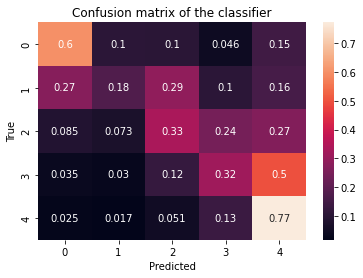

In [14]:
# Plot a confusion matrix
cm = confusion_matrix(y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [51]:
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise import SVDpp, SVD

reader = Reader(rating_scale=(1, 5), line_format='user item timestamp rating')

trainset = Dataset.load_from_df(pd.concat([x_train[['UserId', 'ProductId', 'Time']], y_train], axis=1), reader)
trainset = trainset.build_full_trainset()
testset = Dataset.load_from_df(pd.concat([x_test[['UserId', 'ProductId', 'Time']], y_test], axis=1), reader)
testset = testset.build_full_trainset().build_testset()

algo = SVDpp()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)
score = accuracy_score(y_test, [round(p.est) for p in predictions])
print(score)

0.30482599720221676


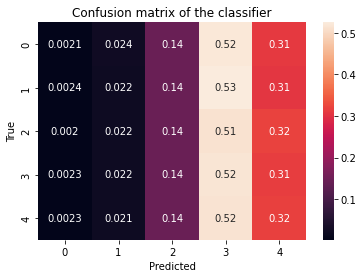

In [54]:
# Plot a confusion matrix
cm = confusion_matrix(y_test, [round(p.est) for p in predictions], normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()